# Insurance cost prediction using linear regression

In this assignment we're going to use information like a person's age, sex, BMI, no. of children and smoking habit to predict the price of yearly medical bills. This kind of model is useful for insurance companies to determine the yearly insurance premium for a person. The dataset for this problem is taken from: https://www.kaggle.com/mirichoi0218/insurance


We will create a model with the following steps:
1. Download and explore the dataset
2. Prepare the dataset for training
3. Create a linear regression model
4. Train the model to fit the data
5. Make predictions using the trained model


This assignment builds upon the concepts from the first 2 lectures. It will help to review these Jupyter notebooks:
- PyTorch basics: https://jovian.ml/aakashns/01-pytorch-basics
- Linear Regression: https://jovian.ml/aakashns/02-linear-regression
- Logistic Regression: https://jovian.ml/aakashns/03-logistic-regression
- Linear regression (minimal): https://jovian.ml/aakashns/housing-linear-minimal
- Logistic regression (minimal): https://jovian.ml/aakashns/mnist-logistic-minimal

As you go through this notebook, you will find a **???** in certain places. Your job is to replace the **???** with appropriate code or values, to ensure that the notebook runs properly end-to-end . In some cases, you'll be required to choose some hyperparameters (learning rate, batch size etc.). Try to experiment with the hypeparameters to get the lowest loss.


In [1]:
# Uncomment and run the commands below if imports fail
# !conda install numpy pytorch torchvision cpuonly -c pytorch -y
# !pip install matplotlib --upgrade --quiet
# !pip install jovian --upgrade --quiet

In [2]:
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

<IPython.core.display.Javascript object>

In [3]:
project_name='02-insurance-linear-regression' # will be used by jovian.commit

## Step 1: Download and explore the data

Let us begin by downloading the data. We'll use the `download_url` function from PyTorch to get the data as a CSV (comma-separated values) file. 

In [4]:
# Commenting this code because file is already downloaded
DATASET_URL = "https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv"
download_url(DATASET_URL, '.')

Using downloaded and verified file: .\insurance.csv


In [5]:
DATA_FILENAME = "insurance.csv"

To load the dataset into memory, we'll use the `read_csv` function from the `pandas` library. The data will be loaded as a Pandas dataframe. See this short tutorial to learn more: https://data36.com/pandas-tutorial-1-basics-reading-data-files-dataframes-data-selection/

In [6]:
dataframe_raw = pd.read_csv(DATA_FILENAME)
dataframe_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We're going to do a slight customization of the data, so that you every participant receives a slightly different version of the dataset. Fill in your name below as a string (enter at least 5 characters)

In [7]:
your_name = "saurabhjain" # at least 5 characters

The `customize_dataset` function will customize the dataset slightly using your name as a source of random numbers.

In [8]:
def customize_dataset(dataframe_raw, rand_str):
    dataframe = dataframe_raw.copy(deep=True)
    # drop some rows
    dataframe = dataframe.sample(int(0.95*len(dataframe)), random_state=int(ord(rand_str[0])))
    # scale input
    dataframe.bmi = dataframe.bmi * ord(rand_str[1])/100.
    # scale target
    dataframe.charges = dataframe.charges * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['region'], axis=1)
    return dataframe

In [9]:
dataframe = customize_dataset(dataframe_raw, your_name)
dataframe.head()

,age,sex,bmi,children,smoker,region,charges
1178,23,female,33.81905,0,no,northeast,3392.402539
1295,20,male,21.34000,1,no,southwest,2298.792600
205,28,female,28.01360,1,no,northeast,5075.150184
1067,39,male,41.37535,0,no,northeast,6736.173736
523,38,female,36.59810,0,no,southeast,6315.211539


Let us answer some basic questions about the dataset. 


**Q: How many rows does the dataset have?**

In [10]:
num_rows = dataframe.shape[0]
print(num_rows)

1271


**Q: How many columns doe the dataset have**

In [11]:
num_cols = dataframe.shape[1]
print(num_cols)

7


**Q: What are the column titles of the input variables?**

In [12]:
dataframe.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [13]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1271 entries, 1178 to 604
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1271 non-null   int64  
 1   sex       1271 non-null   object 
 2   bmi       1271 non-null   float64
 3   children  1271 non-null   int64  
 4   smoker    1271 non-null   object 
 5   region    1271 non-null   object 
 6   charges   1271 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 79.4+ KB


In [14]:
input_cols = ['age', 'sex', 'bmi', 'children', 'smoker', 'region']
input_cols

['age', 'sex', 'bmi', 'children', 'smoker', 'region']

**Q: Which of the input columns are non-numeric or categorial variables ?**

Hint: `sex` is one of them. List the columns that are not numbers.

In [15]:
categorical_cols = ['sex', 'smoker', 'region']
categorical_cols

['sex', 'smoker', 'region']

**Q: What are the column titles of output/target variable(s)?**

In [16]:
output_cols = ['charges']
output_cols

['charges']

**Q: (Optional) What is the minimum, maximum and average value of the `charges` column? Can you show the distribution of values in a graph?**
Use this data visualization cheatsheet for referece: https://jovian.ml/aakashns/dataviz-cheatsheet

In [17]:
# Write your answer here
dataframe['charges'].describe()

count     1271.000000
mean     15579.435606
std      14276.826744
min       1312.592463
25%       5532.932779
50%      11015.456400
75%      19401.102168
max      74611.400772
Name: charges, dtype: float64

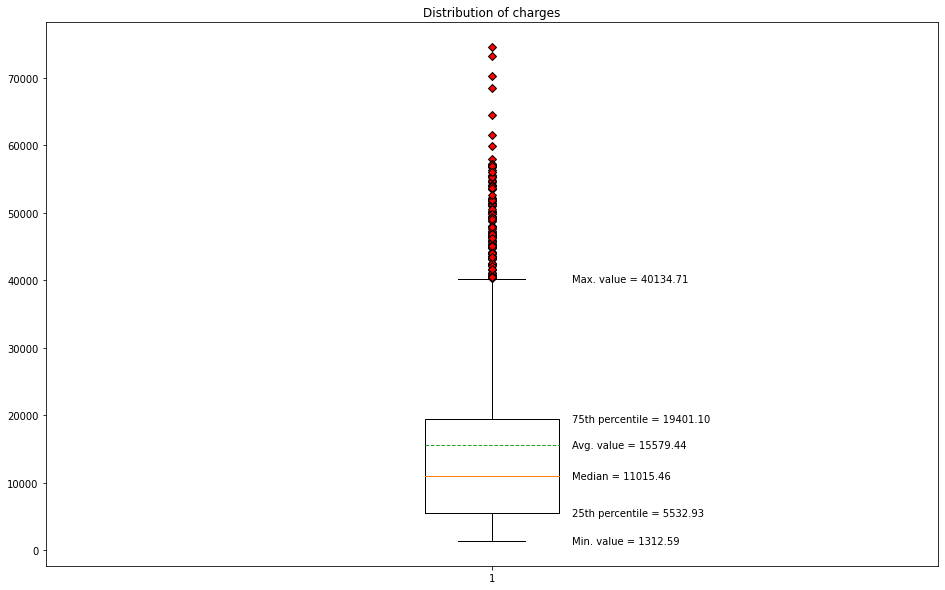

In [18]:
# https://stackoverflow.com/a/55650457/3187537
def make_labels(ax, boxplot):

    # Grab the relevant Line2D instances from the boxplot dictionary
    iqr = boxplot['boxes'][0]
    caps = boxplot['caps']
    med = boxplot['medians'][0]
    fly = boxplot['fliers'][0]
    avg = boxplot['means'][0]
    # The x position of the median line
    xpos = med.get_xdata()
    
    # Lets make the text have a horizontal offset which is some 
    # fraction of the width of the box
    xoff = 0.10 * (xpos[1] - xpos[0])

    # The x position of the labels
    xlabel = xpos[1] + xoff

    # The median is the y-position of the median line
    #print(med)
    median = med.get_ydata()[1]
    #print(median)
    
    # The mean 
    mean = avg.get_ydata()[1]
   
    # The 25th and 75th percentiles are found from the
    # top and bottom (max and min) of the box
    pc25 = iqr.get_ydata().min()
    pc75 = iqr.get_ydata().max()

    # The caps give the vertical position of the ends of the whiskers
    capbottom = caps[0].get_ydata()[0]
    captop = caps[1].get_ydata()[0]

    # Make some labels on the figure using the values derived above
    ax.text(xlabel, median,
            'Median = {:.2f}'.format(median), va='center')
    ax.text(xlabel, pc25,
            '25th percentile = {:.2f}'.format(pc25), va='center')
    ax.text(xlabel, pc75,
            '75th percentile = {:.2f}'.format(pc75), va='center')
    ax.text(xlabel, capbottom,
            'Min. value = {:.2f}'.format(capbottom), va='center')
    ax.text(xlabel, captop,
            'Max. value = {:.2f}'.format(captop), va='center')
    ax.text(xlabel, mean,
             'Avg. value = {:.2f}'.format(mean), va='center')

    
# Make the figure
red_diamond = dict(markerfacecolor='r', marker='D')
fig3, ax3 = plt.subplots(figsize=(16, 10))
ax3.set_title('Distribution of charges')

# Create the boxplot and store the resulting python dictionary
my_boxes = ax3.boxplot(dataframe['charges'], flierprops=red_diamond, showmeans=True, meanline = True)

# Call the function to make labels
make_labels(ax3, my_boxes)

plt.show()

Remember to commit your notebook to Jovian after every step, so that you don't lose your work.

In [19]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..


[jovian] Error: Failed to detect notebook filename. Please provide the correct notebook filename as the "filename" argument to "jovian.commit".


## Step 2: Prepare the dataset for training

We need to convert the data from the Pandas dataframe into a PyTorch tensors for training. To do this, the first step is to convert it numpy arrays. If you've filled out `input_cols`, `categorial_cols` and `output_cols` correctly, this following function will perform the conversion to numpy arrays.

In [20]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    
    return inputs_array, targets_array

Read through the [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) to understand how we're converting categorical variables into numbers.

In [21]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array, targets_array

(array([[23.     ,  0.     , 33.81905,  0.     ,  0.     ,  0.     ],
        [20.     ,  1.     , 21.34   ,  1.     ,  0.     ,  3.     ],
        [28.     ,  0.     , 28.0136 ,  1.     ,  0.     ,  0.     ],
        ...,
        [53.     ,  0.     , 25.899  ,  2.     ,  0.     ,  3.     ],
        [26.     ,  1.     , 26.2482 ,  0.     ,  1.     ,  2.     ],
        [19.     ,  0.     , 27.4607 ,  0.     ,  1.     ,  1.     ]]),
 array([[ 3392.4025395],
        [ 2298.7926   ],
        [ 5075.150184 ],
        ...,
        [13046.4126   ],
        [19940.709438 ],
        [20438.711163 ]]))

**Q: Convert the numpy arrays `inputs_array` and `targets_array` into PyTorch tensors. Make sure that the data type is `torch.float32`.**

In [22]:
inputs = torch.from_numpy(inputs_array).float()
targets = torch.from_numpy(targets_array).float()

In [23]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a `TensorDataset`.

In [24]:
dataset = TensorDataset(inputs, targets)

**Q: Pick a number between `0.1` and `0.2` to determine the fraction of data that will be used for creating the validation set. Then use `random_split` to create training & validation datasets. **

In [25]:
val_percent = 0.1 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size


train_ds, val_ds = random_split(dataset, [train_size, val_size]) # Use the random_split function to split dataset into 2 parts of the desired length

Finally, we can create data loaders for training & validation.

**Q: Pick a batch size for the data loader.**

In [62]:
batch_size = 256

In [63]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

Let's look at a batch of data to verify everything is working fine so far.

In [64]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[39.0000,  0.0000, 33.0770,  3.0000,  0.0000,  3.0000],
        [28.0000,  0.0000, 16.7713,  0.0000,  0.0000,  0.0000],
        [34.0000,  1.0000, 21.7474,  2.0000,  0.0000,  0.0000],
        ...,
        [29.0000,  0.0000, 30.2252,  0.0000,  0.0000,  0.0000],
        [28.0000,  1.0000, 32.8054,  0.0000,  0.0000,  1.0000],
        [47.0000,  1.0000, 34.9976,  1.0000,  1.0000,  2.0000]])
targets: tensor([[ 8679.6709],
        [ 4367.1714],
        [32029.8086],
        [43856.8047],
        [10067.2461],
        [ 8920.8174],
        [ 4954.8647],
        [ 9040.8867],
        [23072.0430],
        [ 3953.3247],
        [10041.2939],
        [29697.2871],
        [13205.2500],
        [ 5187.0635],
        [ 2003.3055],
        [19989.7637],
        [ 2200.1697],
        [11750.6016],
        [ 3535.5166],
        [ 7338.7983],
        [11172.9912],
        [28706.7676],
        [ 1905.3109],
        [27248.0469],
        [13977.5527],
        [50290.6445],
        [1064

Let's save our work by committing to Jovian.

In [29]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..


[jovian] Error: Failed to detect notebook filename. Please provide the correct notebook filename as the "filename" argument to "jovian.commit".


## Step 3: Create a Linear Regression Model

Our model itself is a fairly straightforward linear regression (we'll build more complex models in the next assignment). 


In [65]:
input_size = len(input_cols)
output_size = len(output_cols)

**Q: Complete the class definition below by filling out the constructor (`__init__`), `forward`, `training_step` and `validation_step` methods.**

Hint: Think carefully about picking a good loss fuction (it's not cross entropy). Maybe try 2-3 of them and see which one works best. See https://pytorch.org/docs/stable/nn.functional.html#loss-functions

In [66]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)                  # fill this (hint: use input_size & output_size defined above)
        
    def forward(self, xb):
        out = self.linear(xb)                          # fill this
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.l1_loss(out, targets)                          # fill this
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(out, targets)                           # fill this    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

Let us create a model using the `InsuranceModel` class. You may need to come back later and re-run the next cell to reinitialize the model, in case the loss becomes `nan` or `infinity`.

In [67]:
model = InsuranceModel()

Let's check out the weights and biases of the model using `model.parameters`.

In [68]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.2158, -0.2330, -0.0527, -0.2446,  0.0716, -0.3923]],
        requires_grad=True),
 Parameter containing:
 tensor([0.2563], requires_grad=True)]

One final commit before we train the model.

In [69]:
# jovian.commit(project=project_name, environment=None)

## Step 4: Train the model to fit the data

To train our model, we'll use the same `fit` function explained in the lecture. That's the benefit of defining a generic training loop - you can use it for any problem.

In [70]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

**Q: Use the `evaluate` function to calculate the loss on the validation set before training.**

In [71]:
result = evaluate(model, val_loader) # Use the the evaluate function
print(result)

{'val_loss': 19247.181640625}



We are now ready to train the model. You may need to run the training loop many times, for different number of epochs and with different learning rates, to get a good result. Also, if your loss becomes too large (or `nan`), you may have to re-initialize the model by running the cell `model = InsuranceModel()`. Experiment with this for a while, and try to get to as low a loss as possible.

**Q: Train the model 4-5 times with different learning rates & for different number of epochs.**

Hint: Vary learning rates by orders of 10 (e.g. `1e-2`, `1e-3`, `1e-4`, `1e-5`, `1e-6`) to figure out what works.

In [72]:
epochs = 1000
lr = 10 ** -5
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 19244.7246
Epoch [40], val_loss: 19242.2637
Epoch [60], val_loss: 19239.8027
Epoch [80], val_loss: 19237.3438
Epoch [100], val_loss: 19234.8848
Epoch [120], val_loss: 19232.4238
Epoch [140], val_loss: 19229.9707
Epoch [160], val_loss: 19227.5078
Epoch [180], val_loss: 19225.0430
Epoch [200], val_loss: 19222.5820
Epoch [220], val_loss: 19220.1211
Epoch [240], val_loss: 19217.6562
Epoch [260], val_loss: 19215.1973
Epoch [280], val_loss: 19212.7383
Epoch [300], val_loss: 19210.2773
Epoch [320], val_loss: 19207.8223
Epoch [340], val_loss: 19205.3613
Epoch [360], val_loss: 19202.9004
Epoch [380], val_loss: 19200.4375
Epoch [400], val_loss: 19197.9824
Epoch [420], val_loss: 19195.5137
Epoch [440], val_loss: 19193.0566
Epoch [460], val_loss: 19190.6016
Epoch [480], val_loss: 19188.1367
Epoch [500], val_loss: 19185.6719
Epoch [520], val_loss: 19183.2109
Epoch [540], val_loss: 19180.7480
Epoch [560], val_loss: 19178.2852
Epoch [580], val_loss: 19175.8262
Epoch [600], val_l

In [73]:
epochs = 2000
lr = 10 ** -4
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 19099.5566
Epoch [40], val_loss: 19074.9375
Epoch [60], val_loss: 19050.3262
Epoch [80], val_loss: 19025.7188
Epoch [100], val_loss: 19001.1074
Epoch [120], val_loss: 18976.4844
Epoch [140], val_loss: 18951.8789
Epoch [160], val_loss: 18927.2559
Epoch [180], val_loss: 18902.6582
Epoch [200], val_loss: 18878.0527
Epoch [220], val_loss: 18853.4434
Epoch [240], val_loss: 18828.8379
Epoch [260], val_loss: 18804.2285
Epoch [280], val_loss: 18779.5918
Epoch [300], val_loss: 18755.0020
Epoch [320], val_loss: 18730.3867
Epoch [340], val_loss: 18705.7988
Epoch [360], val_loss: 18681.1914
Epoch [380], val_loss: 18656.5781
Epoch [400], val_loss: 18631.9707
Epoch [420], val_loss: 18607.3496
Epoch [440], val_loss: 18582.7598
Epoch [460], val_loss: 18558.1504
Epoch [480], val_loss: 18533.5410
Epoch [500], val_loss: 18508.9199
Epoch [520], val_loss: 18484.3125
Epoch [540], val_loss: 18459.7324
Epoch [560], val_loss: 18435.1387
Epoch [580], val_loss: 18410.5273
Epoch [600], val_l

In [74]:
epochs = 3000
lr = 10 ** -3
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 16468.6465
Epoch [40], val_loss: 16241.9219
Epoch [60], val_loss: 16022.4355
Epoch [80], val_loss: 15814.1201
Epoch [100], val_loss: 15613.3252
Epoch [120], val_loss: 15417.9053
Epoch [140], val_loss: 15226.0430
Epoch [160], val_loss: 15037.9766
Epoch [180], val_loss: 14860.4453
Epoch [200], val_loss: 14689.9717
Epoch [220], val_loss: 14524.7666
Epoch [240], val_loss: 14366.5762
Epoch [260], val_loss: 14219.1260
Epoch [280], val_loss: 14079.6309
Epoch [300], val_loss: 13943.8662
Epoch [320], val_loss: 13816.3066
Epoch [340], val_loss: 13696.3340
Epoch [360], val_loss: 13581.1562
Epoch [380], val_loss: 13473.2988
Epoch [400], val_loss: 13371.4902
Epoch [420], val_loss: 13275.4424
Epoch [440], val_loss: 13182.0439
Epoch [460], val_loss: 13091.6904
Epoch [480], val_loss: 13005.2627
Epoch [500], val_loss: 12925.7393
Epoch [520], val_loss: 12849.2939
Epoch [540], val_loss: 12777.0859
Epoch [560], val_loss: 12707.6934
Epoch [580], val_loss: 12640.9326
Epoch [600], val_l

In [75]:
epochs = 3500
lr = 10 ** -2
history4 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 11500.2891
Epoch [40], val_loss: 11492.2773
Epoch [60], val_loss: 11482.8877
Epoch [80], val_loss: 11474.0264
Epoch [100], val_loss: 11463.5713
Epoch [120], val_loss: 11456.0156
Epoch [140], val_loss: 11448.5889
Epoch [160], val_loss: 11440.5742
Epoch [180], val_loss: 11433.7256
Epoch [200], val_loss: 11427.8984
Epoch [220], val_loss: 11421.3779
Epoch [240], val_loss: 11413.8252
Epoch [260], val_loss: 11406.8955
Epoch [280], val_loss: 11400.0156
Epoch [300], val_loss: 11393.3887
Epoch [320], val_loss: 11383.5146
Epoch [340], val_loss: 11375.8154
Epoch [360], val_loss: 11368.4619
Epoch [380], val_loss: 11361.5898
Epoch [400], val_loss: 11355.5869
Epoch [420], val_loss: 11349.2607
Epoch [440], val_loss: 11342.1445
Epoch [460], val_loss: 11333.4980
Epoch [480], val_loss: 11326.9834
Epoch [500], val_loss: 11317.7852
Epoch [520], val_loss: 11313.0020
Epoch [540], val_loss: 11306.7871
Epoch [560], val_loss: 11300.7354
Epoch [580], val_loss: 11292.1094
Epoch [600], val_l

In [76]:
epochs = 20000
lr = 10 ** -1
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 11134.8672
Epoch [40], val_loss: 11136.5674
Epoch [60], val_loss: 11136.0098
Epoch [80], val_loss: 11130.1289
Epoch [100], val_loss: 11131.7520
Epoch [120], val_loss: 11130.1699
Epoch [140], val_loss: 11132.7803
Epoch [160], val_loss: 11127.2383
Epoch [180], val_loss: 11128.7051
Epoch [200], val_loss: 11121.6396
Epoch [220], val_loss: 11123.1523
Epoch [240], val_loss: 11120.6113
Epoch [260], val_loss: 11120.0195
Epoch [280], val_loss: 11125.9834
Epoch [300], val_loss: 11114.0352
Epoch [320], val_loss: 11117.2480
Epoch [340], val_loss: 11114.1963
Epoch [360], val_loss: 11114.4854
Epoch [380], val_loss: 11108.4160
Epoch [400], val_loss: 11111.4072
Epoch [420], val_loss: 11105.9492
Epoch [440], val_loss: 11108.7744
Epoch [460], val_loss: 11111.7109
Epoch [480], val_loss: 11099.3828
Epoch [500], val_loss: 11099.7314
Epoch [520], val_loss: 11103.1270
Epoch [540], val_loss: 11096.3398
Epoch [560], val_loss: 11102.4150
Epoch [580], val_loss: 11100.3770
Epoch [600], val_l

**Q: What is the final validation loss of your model?**

In [77]:
val_loss = history5[-1]
val_loss

{'val_loss': 10423.1259765625}

Let's log the final validation loss to Jovian and commit the notebook

In [78]:
jovian.log_metrics(val_loss=val_loss)

[jovian] Metrics logged.


In [79]:
jovian.commit(filename= '02-insurance-linear', project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "saurabhsjain/02-insurance-linear-regression" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ml/saurabhsjain/02-insurance-linear-regression


'https://jovian.ml/saurabhsjain/02-insurance-linear-regression'

Now scroll back up, re-initialize the model, and try different set of values for batch size, number of epochs, learning rate etc. Commit each experiment and use the "Compare" and "View Diff" options on Jovian to compare the different results.

## Step 5: Make predictions using the trained model

**Q: Complete the following function definition to make predictions on a single input**

In [80]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)                # fill this
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [81]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([63.0000,  0.0000, 30.8460,  0.0000,  0.0000,  3.0000])
Target: tensor([16240.7100])
Prediction: tensor([14825.0752])


In [82]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([31.0000,  1.0000, 25.1569,  1.0000,  0.0000,  1.0000])
Target: tensor([4960.6743])
Prediction: tensor([6388.0127])


In [83]:
input, target = val_ds[23]
predict_single(input, target, model)

Input: tensor([61.0000,  0.0000, 24.3276,  0.0000,  0.0000,  2.0000])
Target: tensor([28680.3164])
Prediction: tensor([15039.4092])


Are you happy with your model's predictions? Try to improve them further.

**I improved the model predictions by increasing the number of epochs and learning rate. Yes, I am happy with the results.**

## (Optional) Step 6: Try another dataset & blog about it

While this last step is optional for the submission of your assignment, we highly recommend that you do it. Try to clean up & replicate this notebook (or [this one](https://jovian.ml/aakashns/housing-linear-minimal), or [this one](https://jovian.ml/aakashns/mnist-logistic-minimal) ) for a different linear regression or logistic regression problem. This will help solidify your understanding, and give you a chance to differentiate the generic patters in machine learning from problem-specific details.

Here are some sources to find good datasets:

- https://lionbridge.ai/datasets/10-open-datasets-for-linear-regression/
- https://www.kaggle.com/rtatman/datasets-for-regression-analysis
- https://archive.ics.uci.edu/ml/datasets.php?format=&task=reg&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table
- https://people.sc.fsu.edu/~jburkardt/datasets/regression/regression.html
- https://archive.ics.uci.edu/ml/datasets/wine+quality
- https://pytorch.org/docs/stable/torchvision/datasets.html

We also recommend that you write a blog about your approach to the problem. Here is a suggested structure for your post (feel free to experiment with it):

- Interesting title & subtitle
- Overview of what the blog covers (which dataset, linear regression or logistic regression, intro to PyTorch)
- Downloading & exploring the data
- Preparing the data for training
- Creating a model using PyTorch
- Training the model to fit the data
- Your thoughts on how to experiment with different hyperparmeters to reduce loss
- Making predictions using the model

As with the previous assignment, you can [embed Juptyer notebook cells & outputs from Jovian](https://medium.com/jovianml/share-and-embed-jupyter-notebooks-online-with-jovian-ml-df709a03064e) into your blog. 

Don't forget to share your work on the forum: https://jovian.ml/forum/t/share-your-work-here-assignment-2/4931

In [ ]:
jovian.commit(project=project_name, environment=None)
jovian.commit(project=project_name, environment=None) # try again, kaggle fails sometimes